# Bayesian A/B Testing

I see the choice in Bayesian vs Frequentist approaches as a matter of regularization. Though there is regularization in frequentist methods it's not used in Hypothesis testing because it biases your estimates. A Bayesian is more accepting of bias as long as it biases the estimates towards a more reasonable answer.

In this example I"ll show how outcomes of a hypothesis test changes when using a Bayesian approach vs Frequentist approach. 

Consider an A/B test where we compare clickthrough rates (“out of X impressions, there have been Y clicks”) of different web pages. There's a BAU method as a control vs multiple alternative designs. We want to discover if any design produces signficant lift

In [118]:
import pandas as pd
import numpy as np
from scipy import stats, special
from matplotlib.transforms import Affine2D
import matplotlib.pyplot as plt
%matplotlib inline

# Generate Data

In [166]:
np.random.seed(301)
num_trts = 6
effects = np.random.normal(.1, .01, num_trts)
samples = [2000, 100, 200, 280, 300, 50]
trt_name = ['_BAU', 'A', 'B', 'C', 'D', 'E']

results = {}
for i, trt in enumerate(trt_name):
    results[trt]=stats.bernoulli.rvs(effects[i], size=samples[i])
    

In [167]:
def calc_conf_int(res):

    results = pd.DataFrame()
    for key, val in res.items():
        _results = pd.DataFrame({'odds':"{} / {}".format(sum(val==1),len(val)),
                                 'mean': np.mean(val), 
                                 'y': np.sum(val), 
                                 'n': len(val), 
                                 'se':np.std(val)/np.sqrt(len(val))}, 
                                index=[key])
        results = pd.concat((_results, results))
    results = results.sort_index()
    results['conf_lb'] = results['mean'] - results['se']*1.96
    results['conf_ub'] = results['mean'] + results['se']*1.96
    results.index = results.index + ": " + results.odds
    return results
        

In [168]:
ss = calc_conf_int(results) # summary stats
ss

,mean,n,odds,se,y,conf_lb,conf_ub
A: 10 / 100,0.100000,100,10 / 100,0.030000,10,0.041200,0.158800
B: 32 / 200,0.160000,200,32 / 200,0.025923,32,0.109191,0.210809
C: 34 / 280,0.121429,280,34 / 280,0.019520,34,0.083170,0.159687
D: 27 / 300,0.090000,300,27 / 300,0.016523,27,0.057615,0.122385
E: 9 / 50,0.180000,50,9 / 50,0.054332,9,0.073509,0.286491
_BAU: 210 / 2000,0.105000,2000,210 / 2000,0.006855,210,0.091565,0.118435


(0, 0.3)

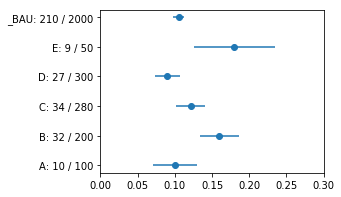

In [169]:
plt.figure(figsize=(4,3))
plt.errorbar(x=ss['mean'], y=ss.index, xerr=ss['se'], fmt='o')
plt.xlim(0, .30)

# Reading Lift

We will take two approaches to reading lift. First the frequentist approach which uses only the data from test/control when determining statistical signficance. Next we explore the Bayesian approach, which incorporates our prior knowledge through the prior

For the Frequestist approach we use a two proportions test:
https://www.socscistatistics.com/tests/ztest/

The Bayesian model will be Beta-Binomial
https://en.wikipedia.org/wiki/Beta-binomial_distribution

## Frequentist Approach

In [189]:
lift = ss.copy()
ctrl_idx = lift.index=='_BAU: 210 / 2000'

# Calculate Mean difference and Pooled Standard Error
lift['var'] = lift['mean']*(1-lift['mean'])
lift['pooled_stderr'] = np.sqrt(lift['var']/lift['n'] + lift[ctrl_idx]['var'].values/lift[ctrl_idx]['n'].values)
lift['mean'] = lift['mean'] - lift[ctrl_idx]['mean'].values

#lift = lift[~ctrl_idx]

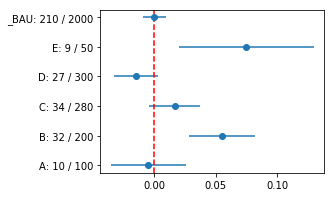

In [190]:
plt.figure(figsize=(4,3))
plt.errorbar(x=lift['mean'], y=lift.index, xerr=lift['pooled_stderr'], fmt='o')
plt.axvline(x=0, color='red', linestyle='--')

### Results

It looks like experience E and B have a significant effect at alpha=.05

## Bayesian Beta-Binomial approach


There are multiple choice we can make for a prior. The choice the prior comes down to what prior beliefs we have, how strong those beliefs are, and the cost of making the wrong decision. 

For example we may have very little prior knowledge and decide to use an uninformative beta(1, 1) distribution. We make also want to be very conservative in our decision making and want to regularize towards the lowest risk option (e.g. BAU). The third I'll explore is regressing each treatment mean to a shared group mean.

- For more information on priors see the [Stan Prior Choice Guide](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) by the stan development team

**Think of alpha = # successes, Beta = # failures**

### Beta-Binomial Conjugacy

The model we will be using is a binomial distribution with a beta prior. I will not go into details since it widely tutorialed on youtube. All you need to know is the posterior predictive distribution is:

$$
y \sim Beta(\alpha_{0} + y, \beta_{0} + n - y)\\
$$

$n$ = trials

$y$ = success

$\alpha_{0}$ = alpha parameter in prior

$\beta_{0}$ = Beta parameter in prior


https://www.evanmiller.org/bayesian-ab-testing.html#binary_ab_derivation


In [191]:
def AB_diff(alpha_A, beta_A,
            alpha_B, beta_B):
    
    """
    Use simulation to find difference between two independent beta distributions
    """
    
    A = np.random.beta(alpha_A, beta_A, 10000)
    B = np.random.beta(alpha_B, beta_B, 10000)
    diff = B-A
    return diff
    
    

### Uninformative Prior: Beta(1,1)

This means we don't have enough intuition to introduce any bias into the model. The results will line up pretty closely with the Frequentist approach

In [192]:
alpha_prior = 1
beta_prior = 1

In [193]:
# Calculate Mean difference and Pooled Standard Error
lift['alpha_unf'] = alpha_prior + lift['y']
lift['Beta_unf'] = beta_prior + lift['n'] - lift['y']

# BAU values
A_alpha_unf = lift.loc[ctrl_idx, 'alpha_unf'][0]
A_Beta_unf = lift.loc[ctrl_idx, 'Beta_unf'][0]

ctrl_idx = lift.index=='_BAU: 210 / 2000'

In [194]:
lift['bayes_unf_mean'] = lift.apply(lambda df : np.mean(
                                                    AB_diff(A_alpha_unf, A_Beta_unf,
                                                    df['alpha_unf'], df['Beta_unf'])
                                                    ), axis=1)

lift['bayes_unf_std'] = lift.apply(lambda df : np.std(
                                                    AB_diff(A_alpha_unf, A_Beta_unf,
                                                    df['alpha_unf'], df['Beta_unf'])
                                                    ), axis=1)

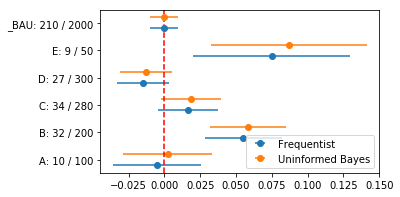

In [195]:
fig, ax = plt.subplots(figsize=(5,3))
trans1 = Affine2D().translate(0.0, -0.2) + ax.transData
trans2 = Affine2D().translate(0.0, +0.2) + ax.transData

plt.errorbar(x=lift['mean'], y=lift.index, xerr=lift['pooled_stderr'], 
             fmt='o', label='Frequentist', transform=trans1)

plt.errorbar(x=lift['bayes_unf_mean'], y=lift.index, xerr=lift['bayes_unf_std'], 
             fmt='o', label='Uninformed Bayes', transform=trans2)

plt.legend()
plt.axvline(x=0, color='red', linestyle='--')

### Prior set to BAU experience (Highly Regularized): Beta(210, 1790))

This prior will significantly bias our results to our BAU data. You might only set this prior if there is a high cost to being wrong about your test experience.

In reality you'll want to find a weighted average between uninformative and highly informed to control/BAU.

In [196]:
alpha_prior = 210
beta_prior = 1790

In [197]:
# Calculate Mean difference and Pooled Standard Error
lift['alpha_inf'] = alpha_prior + lift['y']
lift['Beta_inf'] = beta_prior + lift['n'] - lift['y']

# BAU values
A_alpha_unf = lift.loc[ctrl_idx, 'alpha_inf'][0]
A_Beta_unf = lift.loc[ctrl_idx, 'Beta_inf'][0]

In [198]:
lift['bayes_inf_mean'] = lift.apply(lambda df : np.mean(
                                                    AB_diff(A_alpha_unf, A_Beta_unf,
                                                    df['alpha_inf'], df['Beta_inf'])
                                                    ), axis=1)

lift['bayes_inf_std'] = lift.apply(lambda df : np.std(
                                                    AB_diff(A_alpha_unf, A_Beta_unf,
                                                    df['alpha_inf'], df['Beta_inf'])
                                                    ), axis=1)

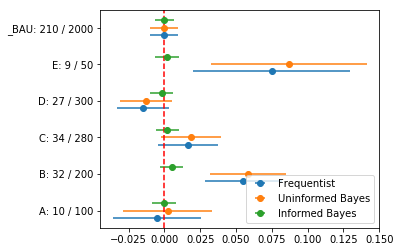

In [199]:
fig, ax = plt.subplots(figsize=(5,4))
trans1 = Affine2D().translate(0.0, -0.2) + ax.transData
trans2 = Affine2D().translate(0.0, +0.0) + ax.transData
trans3 = Affine2D().translate(0.0, +0.2) + ax.transData

plt.errorbar(x=lift['mean'], y=lift.index, xerr=lift['pooled_stderr'], 
             fmt='o', label='Frequentist', transform=trans1)

plt.errorbar(x=lift['bayes_unf_mean'], y=lift.index, xerr=lift['bayes_unf_std'], 
             fmt='o', label='Uninformed Bayes', transform=trans2)

plt.errorbar(x=lift['bayes_inf_mean'], y=lift.index, xerr=lift['bayes_inf_std'], 
             fmt='o', label='Informed Bayes', transform=trans3)

plt.legend()
plt.axvline(x=0, color='red', linestyle='--')

## Observations

1. The uninformed prior adds in almost no regularization to our results and produces a result very similar to the frequentist method

2. Using our BAU web page as a prior strongly regularizes each test. This may provide too conservative of a result. Instead we may wish to 

In some ways you might consider the setting of the prior "arbitrary", which is why I encourage to only use a strong prior when there is strong inuition to do so. Alternately, you can use a hierarchical prior which I discuss in another blog post